# Lesson 3 Module 5: Bootstrap

This notebook demonstrates bootstrap methods for confidence interval construction.
It complements parametric confidence intervals and builds on Lesson 1 (sampling distributions).

## Learning Objectives
- Explain the bootstrap idea: resampling to approximate sampling distributions
- Implement percentile and basic bootstrap confidence intervals
- Apply bootstrap to non-smooth statistics (median, quantiles)
- Compare bootstrap CI coverage to parametric methods

## Repository Context
- Uses `bootstrap_stat()` function from the appendix
- Uses `shared/data/heights_weights_sample.csv` for practical examples
- Complements confidence intervals from previous module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style and random seed
sns.set_theme(context="talk", style="whitegrid")
sns.set_palette(["#000000", "#E69F00", "#56B4E9", "#009E73",
                 "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
rng = np.random.default_rng(2025)

print("Environment setup complete. Random seed: 2025")

Environment setup complete. Random seed: 2025


## 1. Bootstrap Function

Using the bootstrap function from the appendix.

In [2]:
def bootstrap_stat(x, stat_fn, B=10_000, alpha=0.05, rng=None):
    """
    Nonparametric bootstrap for a scalar statistic.
    Returns (thetahat, replicates, ci_percentile, ci_basic).
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(x)
    thetahat = stat_fn(x)
    boots = np.empty(B)
    for b in range(B):
        xb = x[rng.integers(0, n, n)]
        boots[b] = stat_fn(xb)
    lo_p, hi_p = np.quantile(boots, [alpha/2, 1-alpha/2])
    ci_percentile = (lo_p, hi_p)
    ci_basic = (2*thetahat - hi_p, 2*thetahat - lo_p)
    return thetahat, boots, ci_percentile, ci_basic

print("Function defined: bootstrap_stat")

Function defined: bootstrap_stat


## 2. Bootstrap for Median (Exponential Data)

Demonstrate bootstrap for a non-smooth statistic where parametric methods are difficult.

In [3]:
# Generate skewed exponential data
true_lambda = 2.0
n = 100
x = rng.exponential(1/true_lambda, n)

print(f"Generated {n} exponential observations (λ = {true_lambda})")
print(f"Sample median: {np.median(x):.4f}")
print(f"Theoretical median: {np.log(2)/true_lambda:.4f}")

Generated 100 exponential observations (λ = 2.0)
Sample median: 0.3358
Theoretical median: 0.3466


In [4]:
# Bootstrap the median
sample_median, boot_medians, ci_percentile, ci_basic = bootstrap_stat(
    x, np.median, B=5000, alpha=0.05, rng=rng
)

print(f"Sample median: {sample_median:.4f}")
print(f"Percentile CI: [{ci_percentile[0]:.4f}, {ci_percentile[1]:.4f}]")
print(f"Basic CI: [{ci_basic[0]:.4f}, {ci_basic[1]:.4f}]")
print(f"True median: {np.log(2)/true_lambda:.4f}")
print(f"Percentile CI contains true value: {ci_percentile[0] <= np.log(2)/true_lambda <= ci_percentile[1]}")
print(f"Basic CI contains true value: {ci_basic[0] <= np.log(2)/true_lambda <= ci_basic[1]}")

Sample median: 0.3358
Percentile CI: [0.2684, 0.5148]
Basic CI: [0.1567, 0.4032]
True median: 0.3466
Percentile CI contains true value: True
Basic CI contains true value: True


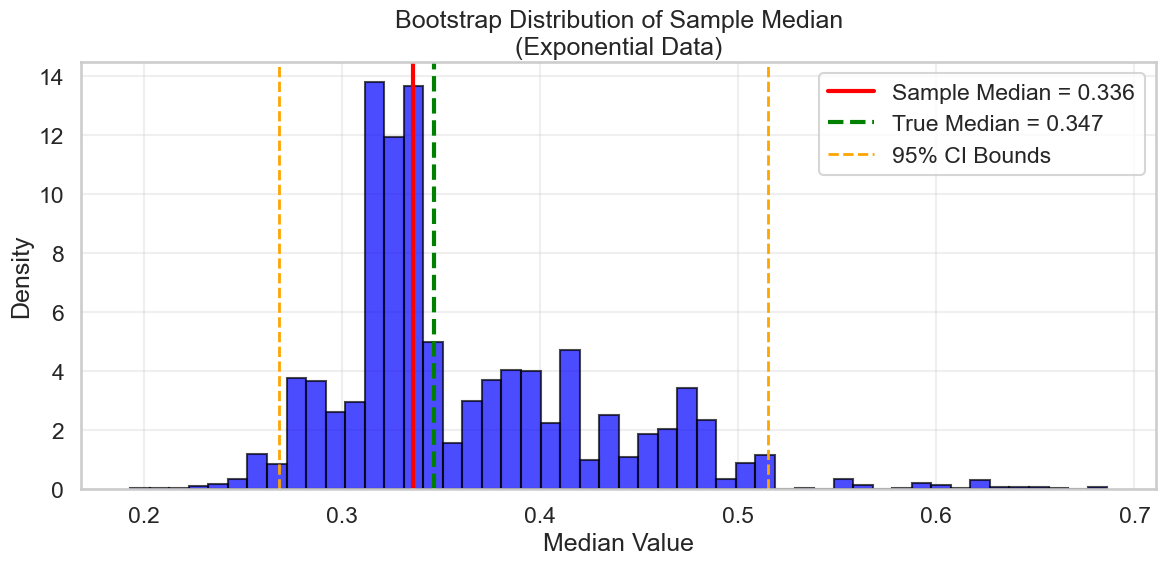

Bootstrap median distribution plot saved


In [9]:
# Plot bootstrap distribution of median
plt.figure(figsize=(12, 6))

# Histogram of bootstrap medians
plt.hist(boot_medians, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')

# Vertical lines
plt.axvline(sample_median, color='red', linewidth=3, label=f'Sample Median = {sample_median:.3f}')
plt.axvline(np.log(2)/true_lambda, color='green', linewidth=3, linestyle='--', label=f'True Median = {np.log(2)/true_lambda:.3f}')
plt.axvline(ci_percentile[0], color='orange', linewidth=2, linestyle='--', label='95% CI Bounds')
plt.axvline(ci_percentile[1], color='orange', linewidth=2, linestyle='--')

plt.xlabel('Median Value')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Sample Median\n(Exponential Data)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bootstrap_median_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Bootstrap median distribution plot saved")

## 3. Bootstrap for Difference in Means

Using heights data to compare bootstrap vs parametric intervals for mean difference.

In [8]:
# Load heights data
heights_df = pd.read_csv("../../../shared/data/heights_weights_sample.csv")
print("Heights data shape:", heights_df.shape)
print("Columns:", heights_df.columns.tolist())

# Separate by sex
male_heights = heights_df[heights_df['sex'] == 'M']['height_cm'].values
female_heights = heights_df[heights_df['sex'] == 'F']['height_cm'].values

print(f"\nMale heights: n = {len(male_heights)}, mean = {np.mean(male_heights):.2f} cm")
print(f"Female heights: n = {len(female_heights)}, mean = {np.mean(female_heights):.2f} cm")
print(f"Mean difference: {np.mean(male_heights) - np.mean(female_heights):.2f} cm")

Heights data shape: (10, 4)
Columns: ['id', 'height_cm', 'weight_kg', 'sex']

Male heights: n = 5, mean = 177.60 cm
Female heights: n = 5, mean = 162.80 cm
Mean difference: 14.80 cm


In [10]:
# Parametric Welch CI
def welch_ci(x1, x2, alpha=0.05):
    """Welch's t-interval for difference in means"""
    n1, n2 = len(x1), len(x2)
    mean1, mean2 = np.mean(x1), np.mean(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)

    # Welch-Satterthwaite degrees of freedom
    se1, se2 = var1/n1, var2/n2
    df_num = (se1 + se2)**2
    df_den = se1**2/(n1-1) + se2**2/(n2-1)
    df = df_num / df_den

    diff = mean1 - mean2
    se_diff = np.sqrt(se1 + se2)
    t_crit = stats.t.ppf(1 - alpha/2, df)

    return diff - t_crit*se_diff, diff + t_crit*se_diff

# Compute parametric CI
welch_lo, welch_hi = welch_ci(male_heights, female_heights)
print(f"Welch CI: [{welch_lo:.3f}, {welch_hi:.3f}] (length: {welch_hi-welch_lo:.3f})")

Welch CI: [7.552, 22.048] (length: 14.496)


In [11]:
# Bootstrap CI for difference in means
def mean_difference(x1, x2):
    return np.mean(x1) - np.mean(x2)

def bootstrap_two_sample(x1, x2, stat_fn, B=5000, alpha=0.05, rng=None):
    """Bootstrap for two-sample statistic"""
    rng = np.random.default_rng() if rng is None else rng
    n1, n2 = len(x1), len(x2)
    thetahat = stat_fn(x1, x2)
    boots = np.empty(B)

    for b in range(B):
        x1_boot = x1[rng.integers(0, n1, n1)]
        x2_boot = x2[rng.integers(0, n2, n2)]
        boots[b] = stat_fn(x1_boot, x2_boot)

    lo_p, hi_p = np.quantile(boots, [alpha/2, 1-alpha/2])
    ci_percentile = (lo_p, hi_p)
    ci_basic = (2*thetahat - hi_p, 2*thetahat - lo_p)

    return thetahat, boots, ci_percentile, ci_basic

# Bootstrap the difference
boot_diff, boot_diffs, boot_percentile, boot_basic = bootstrap_two_sample(
    male_heights, female_heights, mean_difference, B=5000, rng=rng
)

print(f"Bootstrap difference: {boot_diff:.3f}")
print(f"Bootstrap percentile CI: [{boot_percentile[0]:.3f}, {boot_percentile[1]:.3f}]")
print(f"Bootstrap basic CI: [{boot_basic[0]:.3f}, {boot_basic[1]:.3f}]")

Bootstrap difference: 14.800
Bootstrap percentile CI: [9.400, 20.000]
Bootstrap basic CI: [9.600, 20.200]


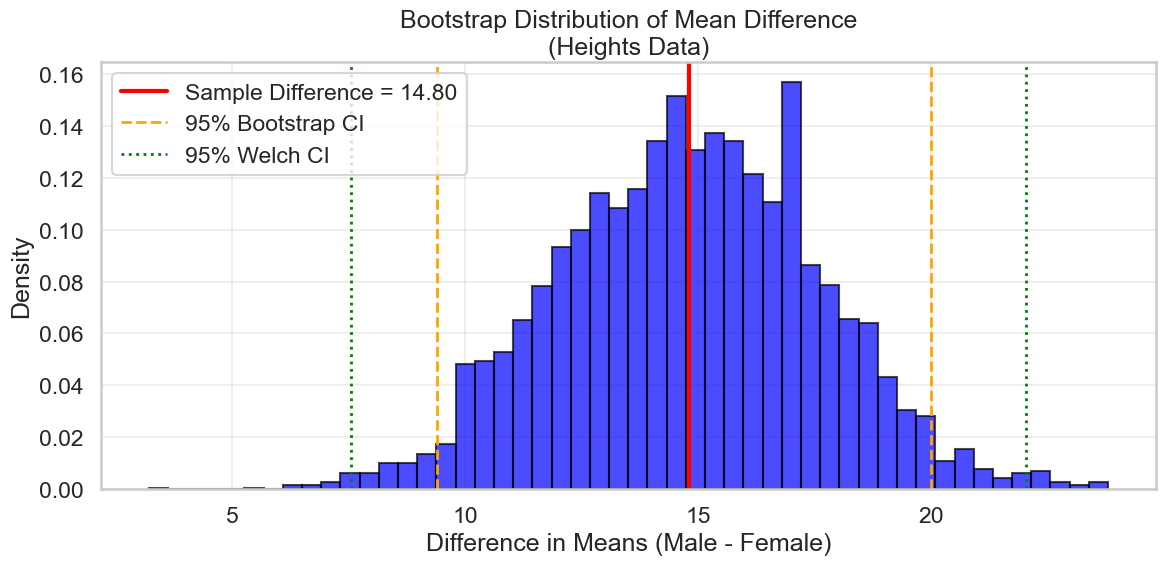

Bootstrap mean difference plot saved


In [12]:
# Plot bootstrap distribution of difference
plt.figure(figsize=(12, 6))

plt.hist(boot_diffs, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')

# Vertical lines
plt.axvline(boot_diff, color='red', linewidth=3, label=f'Sample Difference = {boot_diff:.2f}')
plt.axvline(boot_percentile[0], color='orange', linewidth=2, linestyle='--', label='95% Bootstrap CI')
plt.axvline(boot_percentile[1], color='orange', linewidth=2, linestyle='--')
plt.axvline(welch_lo, color='green', linewidth=2, linestyle=':', label='95% Welch CI')
plt.axvline(welch_hi, color='green', linewidth=2, linestyle=':')

plt.xlabel('Difference in Means (Male - Female)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Mean Difference\n(Heights Data)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bootstrap_mean_difference.png', dpi=150, bbox_inches='tight')
plt.show()

print("Bootstrap mean difference plot saved")

## 4. Studentized Bootstrap

Implement studentized bootstrap for improved performance.

In [13]:
def studentized_bootstrap(x, stat_fn, B=5000, alpha=0.05, rng=None):
    """
    Studentized bootstrap for improved CI coverage.
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(x)
    thetahat = stat_fn(x)

    # Bootstrap statistics and standard errors
    boot_stats = np.empty(B)
    boot_ses = np.empty(B)

    for b in range(B):
        xb = x[rng.integers(0, n, n)]
        boot_stats[b] = stat_fn(xb)
        boot_ses[b] = np.std(xb, ddof=1) / np.sqrt(n)  # SE of mean

    # Studentized statistics
    se_hat = np.std(x, ddof=1) / np.sqrt(n)
    studentized = (boot_stats - thetahat) / boot_ses

    # Quantiles of studentized statistics
    q_lo, q_hi = np.quantile(studentized, [alpha/2, 1-alpha/2])

    # Studentized CI
    ci_studentized = (thetahat - q_hi * se_hat, thetahat - q_lo * se_hat)

    return thetahat, boot_stats, ci_studentized

print("Function defined: studentized_bootstrap")

Function defined: studentized_bootstrap


In [14]:
# Compare bootstrap methods for the mean
sample_mean = np.mean(x)
se_mean = np.std(x, ddof=1) / np.sqrt(len(x))

# Regular bootstrap
theta_reg, boots_reg, ci_percentile_reg, ci_basic_reg = bootstrap_stat(x, np.mean, B=5000, rng=rng)

# Studentized bootstrap
theta_stud, boots_stud, ci_studentized = studentized_bootstrap(x, np.mean, B=5000, rng=rng)

print(f"Sample mean: {sample_mean:.4f}")
print(f"Standard error: {se_mean:.4f}")
print(f"Percentile CI: [{ci_percentile_reg[0]:.4f}, {ci_percentile_reg[1]:.4f}]")
print(f"Basic CI: [{ci_basic_reg[0]:.4f}, {ci_basic_reg[1]:.4f}]")
print(f"Studentized CI: [{ci_studentized[0]:.4f}, {ci_studentized[1]:.4f}]")
print(f"True mean: {1/true_lambda:.4f}")

Sample mean: 0.5796
Standard error: 0.0592
Percentile CI: [0.4697, 0.6941]
Basic CI: [0.4651, 0.6894]
Studentized CI: [0.4740, 0.7129]
True mean: 0.5000


## 5. Bootstrap Performance vs Sample Size

Investigate how bootstrap performance changes with sample size.

In [15]:
def compare_bootstrap_sample_sizes(true_lambda, n_values, B=2000, R=500):
    """
    Compare bootstrap performance across sample sizes.
    """
    results = []

    for n in n_values:
        coverage_percentile = 0
        coverage_basic = 0
        avg_length_percentile = 0
        avg_length_basic = 0

        for r in range(R):
            # Generate data
            x = rng.exponential(1/true_lambda, n)
            true_median = np.log(2)/true_lambda

            # Bootstrap
            sample_med = np.median(x)
            _, boot_meds, ci_p, ci_b = bootstrap_stat(x, np.median, B=B, alpha=0.05, rng=rng)

            # Check coverage
            coverage_percentile += (ci_p[0] <= true_median <= ci_p[1])
            coverage_basic += (ci_b[0] <= true_median <= ci_b[1])

            # Accumulate lengths
            avg_length_percentile += ci_p[1] - ci_p[0]
            avg_length_basic += ci_b[1] - ci_b[0]

        results.append({
            'n': n,
            'percentile_coverage': coverage_percentile / R,
            'basic_coverage': coverage_basic / R,
            'percentile_length': avg_length_percentile / R,
            'basic_length': avg_length_basic / R
        })

    return pd.DataFrame(results)

print("Function defined: compare_bootstrap_sample_sizes")

Function defined: compare_bootstrap_sample_sizes


In [16]:
# Compare across sample sizes
n_values = [10, 20, 50, 100, 200]
bootstrap_comparison = compare_bootstrap_sample_sizes(2.0, n_values, B=1000, R=200)
print("Bootstrap performance vs sample size:")
print(bootstrap_comparison.round(4))

Bootstrap performance vs sample size:
     n  percentile_coverage  basic_coverage  percentile_length  basic_length
0   10                0.960           0.785             0.6347        0.6347
1   20                0.955           0.835             0.4252        0.4252
2   50                0.945           0.890             0.2726        0.2726
3  100                0.900           0.865             0.1942        0.1942
4  200                0.945           0.910             0.1349        0.1349


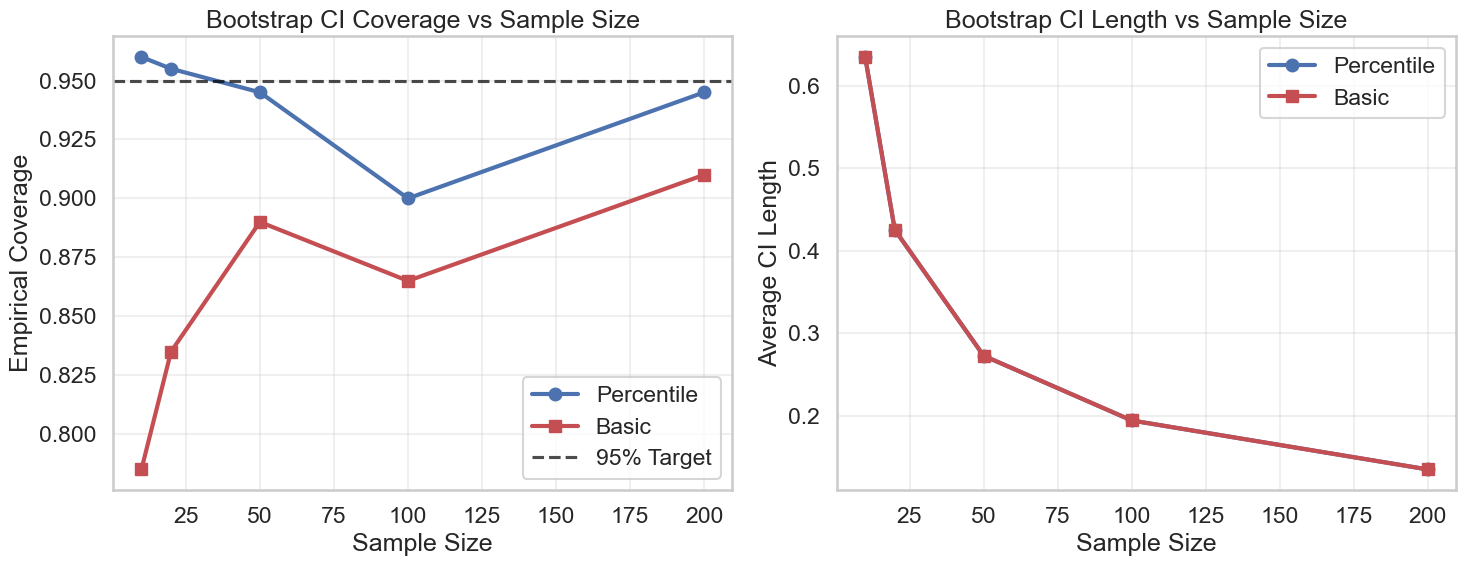

Bootstrap sample size comparison plot saved


In [17]:
# Plot bootstrap performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Coverage vs sample size
axes[0].plot(bootstrap_comparison['n'], bootstrap_comparison['percentile_coverage'], 'b-', linewidth=3, marker='o', label='Percentile')
axes[0].plot(bootstrap_comparison['n'], bootstrap_comparison['basic_coverage'], 'r-', linewidth=3, marker='s', label='Basic')
axes[0].axhline(0.95, color='black', linestyle='--', alpha=0.7, label='95% Target')
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Empirical Coverage')
axes[0].set_title('Bootstrap CI Coverage vs Sample Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Length vs sample size
axes[1].plot(bootstrap_comparison['n'], bootstrap_comparison['percentile_length'], 'b-', linewidth=3, marker='o', label='Percentile')
axes[1].plot(bootstrap_comparison['n'], bootstrap_comparison['basic_length'], 'r-', linewidth=3, marker='s', label='Basic')
axes[1].set_xlabel('Sample Size')
axes[1].set_ylabel('Average CI Length')
axes[1].set_title('Bootstrap CI Length vs Sample Size')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bootstrap_sample_size_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Bootstrap sample size comparison plot saved")

## 6. Summary and Key Takeaways

This notebook demonstrated:
1. Bootstrap for non-smooth statistics like the median
2. Bootstrap for two-sample problems using heights data
3. Comparison of different bootstrap CI methods
4. How bootstrap performance improves with sample size

Key insights:
- Bootstrap provides robust inference without parametric assumptions
- Percentile and basic intervals are easy to implement and interpret
- Bootstrap excels for complex statistics where parametric methods fail
- Performance improves with larger sample sizes and more resamples
- Heights data provides realistic examples for two-sample inference